In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.ndimage.interpolation import shift

from get_hierarchical_df import hierarchical_df

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

plt.rcParams.update({'font.size': 12,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'lines.linewidth': 2,
                    'axes.labelsize': 12,
                    'figure.figsize': (8, 4)})

df = hierarchical_df('transformed_csvs/EBOV-Cyno-Aero-2_transformed.csv')

MA_WINDOW = 48

In [3]:
exp_index = list(df.loc['e2012'].loc['Temp_Mean']['Day']).index(0)
subj_df = df.loc['e2012']

before_exp_temp = subj_df.loc['Temp_Mean']['Moving_Average'][MA_WINDOW:exp_index]
before_exp_resp = subj_df.loc['RespMean_Mean']['Moving_Average'][MA_WINDOW:exp_index]
before_exp_hr = subj_df.loc['HR_Mean']['Moving_Average'][MA_WINDOW:exp_index]
before_exp_rr = subj_df.loc['RR_Mean']['Moving_Average'][MA_WINDOW:exp_index]
before_exp_aopa = subj_df.loc['AOPAMean_Mean']['Moving_Average'][MA_WINDOW:exp_index]

after_exp_temp = subj_df.loc['Temp_Mean']['Moving_Average'][exp_index:]
after_exp_resp = subj_df.loc['RespMean_Mean']['Moving_Average'][exp_index:]
after_exp_hr = subj_df.loc['HR_Mean']['Moving_Average'][exp_index:]
after_exp_rr = subj_df.loc['RR_Mean']['Moving_Average'][exp_index:]
after_exp_aopa = subj_df.loc['AOPAMean_Mean']['Moving_Average'][exp_index:]

-30.0


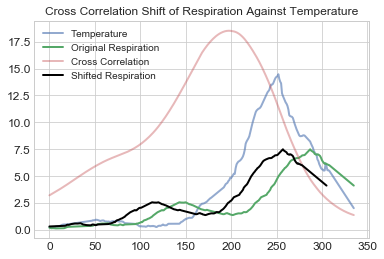

In [4]:
plt.plot(after_exp_temp, label='Temperature', alpha=0.6)
plt.plot(after_exp_resp, label='Original Respiration')
plt.plot(np.correlate(after_exp_resp, after_exp_temp, mode='same') / len(after_exp_temp), alpha=0.4, label='Cross Correlation')
frames = np.ceil(len(after_exp_temp) / 2) - np.argmax(np.correlate(after_exp_resp, after_exp_temp, mode='same') / len(after_exp_temp))
shifted = shift(after_exp_resp, frames, cval=np.NaN)
plt.plot(shifted, label='Shifted Respiration', color='k')
plt.legend()
plt.title('Cross Correlation Shift of Respiration Against Temperature')
print(frames)

-77.0


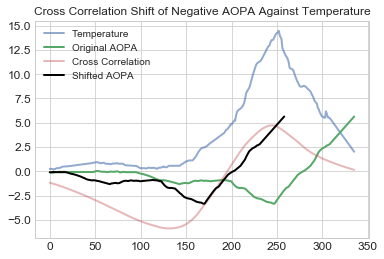

In [5]:
plt.plot(after_exp_temp, label='Temperature', alpha=0.6)
plt.plot(-after_exp_aopa, label='Original AOPA')
plt.plot(np.correlate(-after_exp_aopa, after_exp_temp, mode='same') / len(after_exp_temp), alpha=0.4, label='Cross Correlation')
offset = np.ceil(len(after_exp_temp) / 2) - np.argmax(np.correlate(-after_exp_aopa, after_exp_temp, mode='same') / len(after_exp_temp))
shifted = shift(-after_exp_aopa, offset, cval=np.NaN)
plt.plot(shifted, label='Shifted AOPA', color='k')
plt.legend()
plt.title('Cross Correlation Shift of Negative AOPA Against Temperature')
print(offset)

In [46]:
def cross_corr_offset(in1, in2, negative=0):
    corr = np.correlate(in1, in2, mode='same') / len(in1)
        
    if negative == 1:
        corr = np.correlate(in1, -in2, mode='same') / len(in1)
        
    # Divide by 2 and subtract since mode of correlation centers data
    ret = max(corr)
    offset = -(np.ceil(len(in1) / 2) - np.argmax(corr))
                      
    return (offset, ret)

def cross_corr_subj(df, subj, feature, before_after=1, ma_std=1, negative=0):
    exp_index = list(df.loc[subj].loc['Temp_Mean']['Day']).index(0)
    subj_df = df.loc[subj]
    
    if feature not in subj_df.index:
        return
    
    if before_after == 0:
        if ma_std == 1:
            before_exp_temp = subj_df.loc[
                'Temp_Mean'][
                'Standard_Dev'][MA_WINDOW:exp_index]
            before_exp_fet = subj_df.loc[
                feature][
                'Standard_Dev'][MA_WINDOW:exp_index]
            return cross_corr_offset(
                before_exp_temp, before_exp_fet, negative)
        before_exp_temp = subj_df.loc[
            'Temp_Mean'][
            'Moving_Average'][MA_WINDOW:exp_index]
        before_exp_fet = subj_df.loc[
            feature][
            'Moving_Average'][MA_WINDOW:exp_index]
        return cross_corr_offset(
            before_exp_temp, before_exp_fet, negative)
    if ma_std == 1:
        after_exp_temp = subj_df.loc[
            'Temp_Mean']['Standard_Dev'][exp_index:]
        after_exp_fet = subj_df.loc[
            feature]['Standard_Dev'][exp_index:]
        return cross_corr_offset(
            after_exp_temp, after_exp_fet, negative)
    after_exp_temp = subj_df.loc[
        'Temp_Mean']['Moving_Average'][exp_index:]
    after_exp_fet = subj_df.loc[
        feature]['Moving_Average'][exp_index:]
    return cross_corr_offset(after_exp_temp, 
                             after_exp_fet, 
                             negative)


def gen_cross_corr_df(csv):
    df = hierarchical_df(csv)

    subjs = np.unique(df.index.get_level_values(0))
    features_positive = ['RespMean_Mean', 'HR_Mean']
    features_negative = ['AOPAMean_Mean', 'RR_Mean']
    cols = ['RespMean_Mean_Frames', 'HR_Mean_Frames', 'AOPAMean_Mean_Frames', 
            'RR_Mean_Frames', 'RespMean_Mean_MaxCorr', 'HR_Mean_MaxCorr', 
            'AOPAMean_Mean_MaxCorr', 'RR_Mean_MaxCorr']
    res_df = pd.DataFrame(index=subjs, columns=cols)

    for subj in subjs:
        for feature, frame_col in zip(features_positive, cols[:2]):
            if feature not in df.loc[subj].index:
                continue
            res_df.loc[subj][frame_col] = cross_corr_subj(df, subj, feature, ma_std=0)[0]
        for feature, corr_col in zip(features_positive, cols[4:6]):
            if feature not in df.loc[subj].index:
                continue
            res_df.loc[subj][corr_col] = cross_corr_subj(df, subj, feature, ma_std=0)[1]
        for feature, frame_col in zip(features_negative, cols[2:4]):
            if feature not in df.loc[subj].index:
                continue
            res_df.loc[subj][frame_col] = cross_corr_subj(df, subj, feature, ma_std=0, negative=1)[0]
        for feature, corr_col in zip(features_negative, cols[6:8]):
            if feature not in df.loc[subj].index:
                continue
            res_df.loc[subj][corr_col] = cross_corr_subj(df, subj, feature, ma_std=0, negative=1)[1]
    
    return res_df

In [54]:
ebov_1_cross_corr_df = gen_cross_corr_df('transformed_csvs/EBOV-Cyno-Aero-1_transformed.csv')
ebov_1_cross_corr_df.to_csv('cross_corr_data/ebov_1.csv')

In [55]:
ebov_2_cross_corr_df = gen_cross_corr_df('transformed_csvs/EBOV-Cyno-Aero-2_transformed.csv')
ebov_2_cross_corr_df.to_csv('cross_corr_data/ebov_2.csv')

In [56]:
lassa_cross_corr_df = gen_cross_corr_df('transformed_csvs/LASSA-Cyno-Aero_transformed.csv')
lassa_cross_corr_df.to_csv('cross_corr_data/lassa.csv')

In [57]:
marv_cross_corr_df_1 = gen_cross_corr_df('transformed_csvs/MARV-Cyno-IM_transformed.csv')
marv_cross_corr_df_1.to_csv('cross_corr_data/marv_1.csv')

In [58]:
marv_cross_corr_df_2 = gen_cross_corr_df('transformed_csvs/MARV-Rhesus-Aero_transformed.csv')
marv_cross_corr_df_2.to_csv('cross_corr_data/marv_2.csv')

In [59]:
nipah_corr_df = gen_cross_corr_df('transformed_csvs/NIPAH-AGM-IT_transformed.csv')
nipah_corr_df.to_csv('cross_corr_data/nipah.csv')

In [60]:
plague_corr_df = gen_cross_corr_df('transformed_csvs/Plague-AGM-Aero_transformed.csv')
plague_corr_df.to_csv('cross_corr_data/plague.csv')